In [35]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import stats, integrate
from scipy.optimize import curve_fit
from scipy.interpolate import pade
from scipy.interpolate import approximate_taylor_polynomial
import seaborn as sns
import pandas as pd
import math
import cmath

from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


1. Найти корень уравнения $ax^4 = \cos x$ при $a=1$.

Попробуем реализовать метод парабол, то есть рекуррентную схему $x_{n+1} = x_n - \frac{2f\, \mathrm{sign}(f')}{|f'| + \sqrt{f'^2 - 2ff''}}$.

x1 = 0.89055, x2 = -0.89055


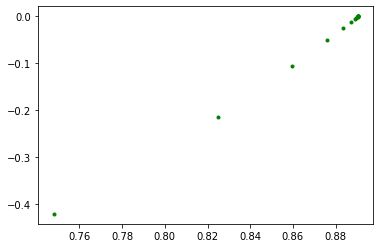

In [83]:
def f(x,a):
    return a*x**4 - math.cos(x)

def first_der(x,a): 
    return a*4*x**3 + math.sin(x)

def second_der(x,a):
    return a*12*x**2 + math.cos(x)
def Muller_method(func,x,a, first_der, second_der):
    return 2*func(x,a)*np.sign(first_der(x,a))/(np.abs(second_der(x,a)) + np.sqrt(first_der(x,a)**2 - 2*func(x,a)*second_der(x,a)))

x = 0.5
for i in range(15):
    x -= Muller_method(f, x, 1, first_der, second_der) 
    plt.plot(x, f(x,1), ".", color = "g")

print(f"x1 = {x:0.5f}, x2 = {-x:0.5f}")

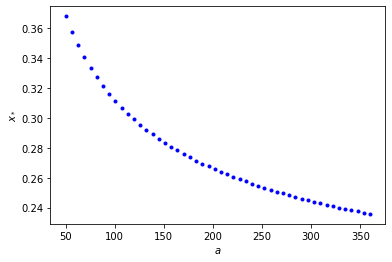

In [84]:
cut = np.linspace(50, 360, num=50)
for a in cut:
    x = 0.3
    for i in range(15):
        x -= Muller_method(f, x, a, first_der, second_der)
    plt.gca().set_xlabel(r"$a$")
    plt.gca().set_ylabel(r"$x_*$")
    plt.plot(a, x, ".", color="b")

3. Построить аппроксимацию зависимости корня $x_*(a)$ от параметра $a$.

Попробуем реализовать аппроксимацию рациональной функцией --- аппроксимацию Паде без знания производных.

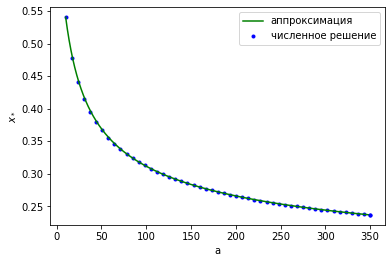

In [93]:
cut = np.linspace(10, 350, num=5)
r = []
y = []
fig, ax = plt.subplots()

for a in cut:
    x = 0.3
    for i in range(15):
        x -= Muller_method(f, x, a, first_der, second_der)
    r.append([-x*a, -x*a**2, 1, a, a**2])
    y.append(x)
#print(r)
coeff = scipy.linalg.solve(np.array(r), y)

def Pade_approx(x, coeff):
    return ((coeff[2] + coeff[3]*x + coeff[4]*np.power(x,2))/(1 + coeff[0]*x + coeff[1]*np.power(x,2)))

cut_begin = 10
cut_end = 350
num = 10**4+1
cut = np.linspace(cut_begin, cut_end, num)

x_star = []
counter = 0

for a in cut:
    x = 0.3
    for i in range(15):
        x -= Muller_method(f, x, a, first_der, second_der)
    x_star.append(x)

    if (counter % 200 == 0):
        ax.plot(a, x, ".", color="b")
    counter += 1 

ax.plot(cut, Pade_approx(cut, coeff), "g", label="аппроксимация")

ax.set_xlabel(r"a")
ax.set_ylabel(r"$x_*$")
plt.plot(a, x, ".", color="b", label="численное решение")
plt.legend()

4. Найти первообразную (неопределённый интеграл) зависимости корня $x_*(a)$ от параметра $a$.

Попробуем реализовать метод Симпсона.

In [86]:
def var_simpson_int(x, num, delta_x, cut_begin, cut_end, coeff):
    h = (cut_end - cut_begin) / (num - 1)
    definite_int = (h/3) * (x[0] + 2*sum(x[:num-2:2]) \
            + 4*sum(x[1:num-1:2]) + x[num-1])
    return definite_int + (Pade_approx(cut_end, coeff) - Pade_approx(cut_end + delta_x, coeff))*delta_x/2 # рассчитываем на смещение delta_x меньше шага h сетки 

f = lambda x: Pade_approx(x, coeff)
y, err = integrate.quad(f, cut_begin, cut_end)

y_self_w = var_simpson_int(x_star, num, 0, cut_begin, cut_end,  coeff)
print(y_self_w)
print(y_self - y)
#print(I_simp - y)


99.91445360678631
-0.13484847840184955


5. Найти производную $d{x_*}/da_0$ в точке $a=1$.

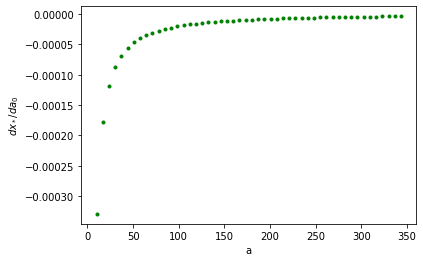

In [140]:
def dv_half(x_star, coeff, cut_begin, cut_end, num, cut):
    h = (cut_end - cut_begin) / (num - 1)
    #dv_0 = (4*Pade_approx(x_star[1], coeff) - Pade_approx(x_star[2], coeff) - 3*Pade_approx(x_star[0], coeff))/(2*h)
    #plt.plot(x_star[0], dv_0, "g")
    #cut = np.linspace(cut_begin-2*h, cut_end-2*h, num)
    for i, a in enumerate(cut):
        if i == num-2:
            break
        #dv = (Pade_approx(x_star[i+1], coeff) - Pade_approx(x_star[i-1], coeff))/(2*h)
        dv = (4*Pade_approx(x_star[i], coeff) - Pade_approx(x_star[i+2], coeff) - 3*Pade_approx(x_star[i], coeff))/(2*h)
        if i%200 == 0:
            plt.plot(a, dv, ".", color="g")
    plt.gca().set_xlabel(r"a")
    plt.gca().set_ylabel(r"$d{x_*}/da_0$") 
    #plt.gca().legend()
dv_half(x_star, coeff, cut_begin, cut_end, num, cut)

На этом задании вспомнил, почему не пользуюсь "ноутбуками" вне dlschool и предпочитаю скрипты; если важно всё-таки посчитать производную при конкрентном значении $a=1$, готов переделать, а сейчас для этого нужно менять участок, на котором берутся точки для вычисления коэффициентов $Pade\_approx$: сейчас при малых значениях параметра $a$ погрешность моей аппроксимации растёт.

2. Найти минимум функции $f(x, y) = \left(x^2 + y - \cos (x+y)\right)^2 + \sin^2 (y-x)$.

(0.0, 10.0)

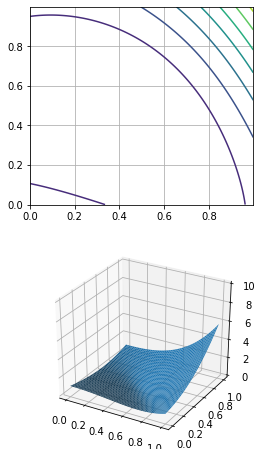

In [6]:
def f(x,y):
    return (x**2 + y - np.cos(x+y))**2 + (np.sin(y-x))**2


t_1 = np.arange(0, 1, 0.001)
t_2 = np.arange(0, 1, 0.001)
t_1, t_2 = np.meshgrid(t_1,t_2)
t_3 = f(t_1,t_2)

fig = plt.figure(figsize=plt.figaspect(2.))

ax = fig.add_subplot(2, 1, 1)

ax.contour(t_1, t_2, t_3)
ax.grid(True)

ax = fig.add_subplot(2, 1, 2, projection='3d')

surf = ax.plot_surface(t_1, t_2, t_3, linewidth=0)
ax.set_zlim(0, 10)

Попробуем реализовать метод градиентного спуска, схема $\mathbf{x}_{n+1} = \mathbf{x}_n + \lambda_\star \nabla F(\mathbf{x}_n)$ которого в данной задаче приобретает вид


0.441, 0.441
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 36
         Gradient evaluations: 9


array([0.44103645, 0.44103728])

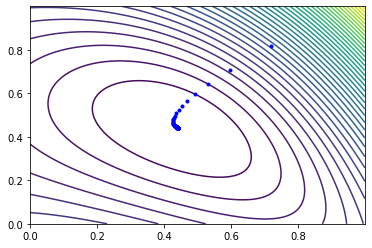

In [7]:
def first_prime_x(x,y):
    return 2*(2*x+np.sin(x+y))*(x**2+y-np.cos(x+y)) + np.sin(2*(x-y))

def first_prime_y(x,y):
    return (2*(1+np.sin(x+y))*(x**2+y-np.cos(x+y)) - np.sin(2*(x-y)))

x = 1
y = 1
omega = 0.02
plt.contour(t_1, t_2, t_3, 50)
for i in range(100):
    x1 = x
    x -= omega*first_prime_x(x,y)
    y -= omega*first_prime_y(x1,y)
    plt.plot(x, y, ".", color="b")
print(f"{x:0.3f}, {y:0.3f}")
x0 = [1, 1]
fun = lambda x: (x[0]**2 + x[1] - np.cos(x[0]+x[1]))**2 + (np.sin(x[1]-x[0]))**2
res = scipy.optimize.minimize(fun, x0, options={'disp': True})
res.x

Честным поиском скорости обучения $omega$ пренебрегли, пользуясь знанием о масштабе задачи и отсутсвием неодходимости "сходиться" к конкретному экстремуму.

Найти решение обыкновенного дифференциального уравнения с заданными начальными условиями: $y'' + \sin(y)^2 = 0$, $y'(0) = 1$, $y(0) = 0$.

Сведём данное ДУ к системе двух уравнений первого порядка:
$y' = u$ и  $u' = - \sin^2 y$, а начальные условия примут вид $y(0) = 0$, $u(0) = 1$. "Разумная гладкость" в наличии, поэтому попробуем воспользоваться методом Рунге-Кутта четвёртого порядка.

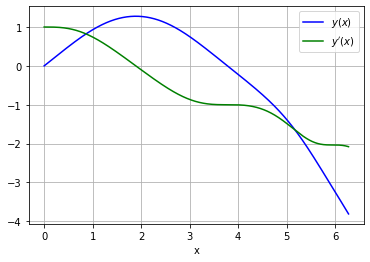

In [41]:
def func(y):
    return -np.power(np.sin(y), 2)

a = 0
b = 2*pi
num = 101
y = 0
u = 1

def RK4(y, u, a, b, num, func):
    h = (b-a)/N
    x_values = np.arange(a,b,h)
    y_values = []
    u_values = []

    for x in x_values:
        y_values.append(y)
        u_values.append(u)

        m1 = h*u
        k1 = h*func(y) 

        m2 = h*(u + 0.5*k1)
        k2 = h*func(y+0.5*m1)

        m3 = h*(u + 0.5*k2)
        k3 = h*func(y+0.5*m2)

        m4 = h*(u + k3)
        k4 = h*func(y+m3)

        y += (m1 + 2*m2 + 2*m3 + m4)/6
        u += (k1 + 2*k2 + 2*k3 + k4)/6

    plt.plot(x_values, y_values, "b-", label=r"$y(x)$")
    plt.plot(x_values, u_values, "g-", label=r"$y'(x)$")
    plt.xlabel('x')
    plt.grid()
    plt.legend()

RK4(y, u, a, b, num, func)

А теперь то же, только используя scipy (комментарии из документации изменены в соответствии с задачей; рассматриваем уравнение $y''(x) + b\cdot y'(x) + c\cdot \sin^2 y =0$).

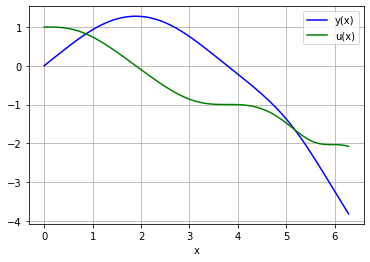

In [42]:
def ode(z, t, b, c):
    y, u = z
    dzdx = [u, -np.power(np.sin(y), 2)]
    return dzdx

b = 0.0
c = 1.0

#The vector of initial conditions is
y0 = [0.0, 1.0]

#We will generate a solution at 101 evenly spaced samples in the interval 0 <= x <= 2*pi. So our array of xes is:
x = np.linspace(0, 2*np.pi, 101)

#Call odeint to generate the solution. To pass the parameters b and c to ODE, we give them to odeint using the args argument.
from scipy.integrate import odeint
sol = odeint(ode, y0, x, args=(b, c))

#The solution is an array with shape (101, 2). The first column is theta(t), and the second is omega(t). The following code plots both components.
plt.plot(x, sol[:, 0], 'b', label='y(x)')
plt.plot(x, sol[:, 1], 'g', label='u(x)')
plt.legend(loc='best')
plt.xlabel('x')
plt.grid()
plt.show()

7. Найти решение параболического уравнения при заданных начальных условиях: $\mathrm{i}u_t = u_{xx} - |u|^2u$ при $u_x(-1,t) = u_x(1, t) = 0$ и $u(x, 0) = \mathrm{e}^{-10x^2}$. По возможности сравнить с точным решением или проверить сохранение интегралов. В ответе должен быть график функции от $x$ и $t$.

Напишем схему Кранк-Никольсона для уравнения $\mathrm{i} u_t = u_{xx}$:
$$\mathrm{i} \bar u_i - \frac{\Delta t}{2\Delta x^2} \left(\bar u_{i+1} - 2 \bar u_i + \bar u_{i-1}\right) = \mathrm{i} u_i - \frac{\Delta t}{2\Delta x^2}\left(u_{i+1} - 2u_i + u_{i-1}\right),$$
для уравнения $\mathrm{i} u_t = - |u|^2 u$ известно решение $\bar u(x) = -u(x) \mathrm{e}^{\mathrm{i} |u(x)|^2 \Delta}$ (для предыдудещго рассмотренного уравнения решение тоже известно, но метод прогонки со сложностью $O(8n)$, который мы попытаемся использовать для решения системы уравнений из приведённой разностной схемы, работает быстрее  FFT со сложностью $O(n\log n)$, которое пришлось бы применять в таком же "split-step" методе, но с двумя аналитическими решениями).

In [37]:
def TDMAsolver(a, b, c, d):
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    for i in range(1, len(d)): # assume a, b, c as diagonal elements, d as free terms column
        mc = ac[i-1]/bc[i-1]
        bc[i] -= mc*cc[i-1] 
        dc[i] -= mc*dc[i-1]
        	    
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for j in range(len(d)-2, -1, -1):
        xc[j] = (dc[j]-cc[j]*xc[j+1])/bc[j]

    return xc

def sol2(u, dt):
    sol = np.array([-u[i]*cmath.exp(1j*np.power(abs(u[i]),2)*dt) for i in range(len(u))])
    return sol

dt = 0.001
x_0 = 1
num_x = 1000
dx = 2*x_0/num_x
num_t = 10
u = np.array([math.exp(-10*np.power(x,2)/(num_x**2)) for x in range(-x_0*num_x, x_0*num_x, 1)])
u_prev = np.array([-dt/(2*np.power(dx,2)) for x in range(-x_0*num_x, x_0*num_x - 1, 1)])
u_i = np.array([1j + dt/(2*np.power(dx,2)) for x in range(-x_0*num_x, x_0*num_x, 1)])
u_next = u_prev

u_list = [u_prev, u_i, u_next]

for t in range(1, num_t):
    sol1 = TDMAsolver(u_prev, u_i, u_next, u)
    #np.vectorize(sol1)
    u = sol2(sol1, dt)
    u_list.append(u)

    #u_prev = u_i
    #u_i = u_next
    #u_next = sol1 

x = np.adx*num for num in range(num_x)]
t = [dt*num for num in range(num_t)]
x, t = np.meshgrid(x,t)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(x, t, u_list)

<ipython-input-37-e089d6107596>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  dc[i] -= mc*dc[i-1]


AttributeError: 'list' object has no attribute 'ndim'

[[25.     22.5625 20.25   ... 18.0625 20.25   22.5625]
 [25.     22.5625 20.25   ... 18.0625 20.25   22.5625]
 [25.     22.5625 20.25   ... 18.0625 20.25   22.5625]
 ...
 [25.     22.5625 20.25   ... 18.0625 20.25   22.5625]
 [25.     22.5625 20.25   ... 18.0625 20.25   22.5625]
 [25.     22.5625 20.25   ... 18.0625 20.25   22.5625]]


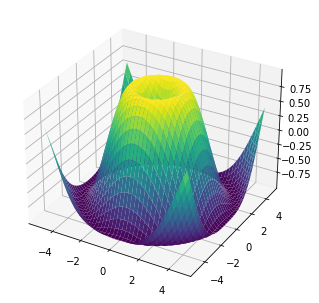

In [34]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
print(X**2)
Z = np.sin(R)

fig = plt.figure()from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.viridis)

plt.show()

In [44]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import stats, integrate
from scipy.optimize import curve_fit
from scipy.interpolate import pade
from scipy.interpolate import approximate_taylor_polynomial
import seaborn as sns
import pandas as pd
import math
import cmath

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def TDMAsolver(a, b, c, d):
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    for i in range(1, len(d)): # assume a, b, c as diagonal elements, d as free terms column
        mc = ac[i-1]/bc[i-1]
        bc[i] -= mc*cc[i-1] 
        dc[i] -= mc*dc[i-1]
        	    
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for j in range(len(d)-2, -1, -1):
        xc[j] = (dc[j]-cc[j]*xc[j+1])/bc[j]

    return xc

def sol2(u, dt):
    sol = np.array([u[i]*cmath.exp(1j*np.power(abs(u[i]),2)*dt) for i in range(len(u))])
    return sol

dt = 0.001
x_0 = 1
num_x = 1000
dx = 2*x_0/num_x
num_t = 10
u = np.array([math.exp(-10*np.power(x,2)/(num_x**2)) for x in range(-x_0*num_x, x_0*num_x, 1)])
u_prev = np.array([-dt/(2*np.power(dx,2)) for x in range(-x_0*num_x, x_0*num_x - 1, 1)])
u_i = np.array([1j + dt/(2*np.power(dx,2)) for x in range(-x_0*num_x, x_0*num_x, 1)])
u_next = u_prev

u_list = u_i.reshape(1, u_i.shape[0])

for t in range(1, num_t):
    sol1 = TDMAsolver(u_prev, u_i, u_next, u)
    #np.vectorize(sol1)
    u = (sol2(sol1, dt)).real
    u_list = np.vstack((u_list, u))

print(u_list.shape)
x = [dx*num for num in range(num_x)]
t = np.array([dt*num for num in range(num_t)])
x, t = np.meshgrid(x,t)
print(x.shape)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(x, t, u_list)

<ipython-input-44-137aea9025d7>:22: ComplexWarning: Casting complex values to real discards the imaginary part
  dc[i] -= mc*dc[i-1]
(10, 2000)
(10, 1000)


ValueError: shape mismatch: objects cannot be broadcast to a single shape